In [1]:
%load_ext autoreload
%autoreload 2

from src.utils.helper import *
import pickle

with open('models/testrun_dyck1_4h/vocab.p', 'rb') as f:
    vocab = pickle.load(f)
    
with open('models/testrun_dyck1_4h/config.p', 'rb') as f:
    config = pickle.load(f)

In [2]:
from src.dataloader import *

data_path = 'data/Dyck-1/train_corpus.pk'
with open(data_path, 'rb') as f:
    train_corpus = pickle.load(f)
    
train_loader = Sampler(train_corpus, vocab, 8)

src, _, wd_lens = train_loader.get_batch(0)
src.shape, wd_lens

['()((()))', '((())((())))', '((((((())(((((((()))))))))))))', '(())()', '(())', '()', '()()', '((((((()))((()((((((()(())))))))()()))))))']


(torch.Size([42, 8]), tensor([ 8, 12, 30,  6,  4,  2,  4, 42]))

In [3]:
def pad_seq(seq, max_length, voc):
    seq += [voc.get_id('T') for i in range(max_length - len(seq))]
    return seq

def sent_to_idx(voc, sent, max_length=-1):
    idx_vec = []
    for w in sent:
        idx = voc.get_id(w)
        idx_vec.append(idx)

    idx_vec.append(voc.get_id('T'))
    idx_vec = pad_seq(idx_vec, max_length+1, voc)
    return idx_vec

def sents_to_idx(voc, sents):
    max_length = max([len(s) for s in sents])
    all_indexes = []
    for sent in sents:
        all_indexes.append(sent_to_idx(voc, sent, max_length))

    all_indexes = torch.tensor(all_indexes, dtype= torch.long)
    return all_indexes

raw = train_corpus.source
data_ids = sents_to_idx(vocab, raw)
data = data_ids[:, :-1]
data.shape

torch.Size([10000, 50])

In [4]:
OPEN = vocab.get_id('(')
CLOSE = vocab.get_id(')')

print(OPEN, CLOSE)

def simulate_stack(tokenised_paren):
    stack = []
    stack_depths = []
    for token in tokenised_paren:
        token = token.item()
        if token == OPEN:
            stack.append(token)
        elif token == CLOSE:
            stack.pop()
        stack_depths.append(len(stack))
    return stack_depths 

1 2


In [5]:
import src
import torch
from src.model import LanguageModel
from src.components.transformers import TransformerModel

import torch

chkpt_path = 'models/testrun_dyck1_4h/model_25.pt'
model = LanguageModel(config, vocab, 'cpu', None)
model.load_state_dict(torch.load(chkpt_path, map_location='cpu')['model_state_dict'])

<All keys matched successfully>

In [6]:
def create_dataset(model, paren_tokens, device="cpu"):
    X = []
    Y = []
    
    model.eval()
    
    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            tokens = tokenised_paren.to(device).unsqueeze(0).T
            output, internal = model.model(tokens, get_encoder_reps=True)
            
            internal = internal.transpose(0, 1).squeeze(0)
            stack_depths = simulate_stack(tokenised_paren)
            
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(stack_depths[i])
    
    # Convert to numpy for normalization
    X = np.array(X)
    
    # Normalize features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    
    return X_tensor, Y_tensor

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [9]:
X, Y = create_dataset(model, data, "cpu")

In [10]:
class ProbingClassifierAblation(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, n_layers=1):
        super(ProbingClassifierAblation, self).__init__()
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, output_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.fc5 = nn.Linear(hidden_size, 256)
        self.fc6 = nn.Linear(256, output_size)
        self.fc7 = nn.Linear(256, hidden_size)
        self.fc8 = nn.Linear(256, 256)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        if self.n_layers == 0:
            out = self.linear(x)
        elif self.n_layers == 1:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 2:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 3:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc3(out)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 4:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc5(out)
            out = self.relu(out)
            out = self.fc8(out)
            out = self.relu(out)
            out = self.fc7(out)
            out = self.relu(out)
            out = self.fc4(out)
        return out

In [11]:
def train_probe_ablation(X, Y, model_name="original", num_epochs=10, batch_size=32, learning_rate=0.001, n_layers = 1):
    input_size = X.shape[1]
    num_classes = Y.max().item() + 1
    print(f"Input Size: {input_size}, Num Classes: {num_classes}")
    
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probing_model = ProbingClassifierAblation(input_size, num_classes, n_layers=n_layers).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(probing_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        probing_model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = probing_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
        
        # Validation phase
        probing_model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = probing_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)

                # Map each `inputs[idx]` back to the token in the sequence
                incorrect_sentences = []
                for idx in incorrect_idx:
                    token_idx = idx.item()
                    token_id = data[token_idx]  # Retrieve token ID
                    token_str = vocab.get_word(token_id.item())  # Convert ID back to token
                    incorrect_sentences.append(token_str)

                print(f"Tokens corresponding to incorrect predictions: {' '.join(incorrect_sentences)}")

        
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(avg_val_loss)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print("-------------------")
    
    return train_accuracies, val_accuracies

In [12]:
traintaskm0, valtaskm0 = train_probe_ablation(X, Y, "Original", n_layers=0)
reainrandomm0, valrandomm0 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=0)
tm0 = max(traintaskm0)
vm0 = max(valtaskm0)
rm0 = max(reainrandomm0)
rv0 = max(valrandomm0)

Input Size: 32, Num Classes: 22
Original - Epoch [1/10]
Train Loss: 1.4145, Train Accuracy: 0.5061
Val Loss: 1.2833, Val Accuracy: 0.5281
-------------------
Original - Epoch [2/10]
Train Loss: 1.2813, Train Accuracy: 0.5220
Val Loss: 1.2685, Val Accuracy: 0.5240
-------------------


KeyboardInterrupt: 

In [ ]:
traintaskm1, valtaskm1 = train_probe_ablation(X, Y, "Original", n_layers=1)
trainrandomm1, valrandomm1 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=1)


Input Size: 32, Num Classes: 22
Original - Epoch [1/10]
Train Loss: 1.2204, Train Accuracy: 0.5383
Val Loss: 1.1928, Val Accuracy: 0.5424
-------------------
Original - Epoch [2/10]
Train Loss: 1.1898, Train Accuracy: 0.5421
Val Loss: 1.1846, Val Accuracy: 0.5425
-------------------
Original - Epoch [3/10]
Train Loss: 1.1858, Train Accuracy: 0.5431
Val Loss: 1.1831, Val Accuracy: 0.5403
-------------------
Original - Epoch [4/10]
Train Loss: 1.1844, Train Accuracy: 0.5430
Val Loss: 1.1835, Val Accuracy: 0.5433
-------------------
Original - Epoch [5/10]
Train Loss: 1.1833, Train Accuracy: 0.5432
Val Loss: 1.1811, Val Accuracy: 0.5491
-------------------
Original - Epoch [6/10]
Train Loss: 1.1824, Train Accuracy: 0.5438
Val Loss: 1.1797, Val Accuracy: 0.5431
-------------------
Original - Epoch [7/10]
Train Loss: 1.1817, Train Accuracy: 0.5437
Val Loss: 1.1790, Val Accuracy: 0.5429
-------------------
Original - Epoch [8/10]
Train Loss: 1.1809, Train Accuracy: 0.5436
Val Loss: 1.1827, V

In [ ]:
tm1 = max(traintaskm1)
vm1 = max(valtaskm1)
rm1 = max(trainrandomm1)
rv1 = max(valrandomm1)

In [ ]:
traintaskm2, valtaskm2 = train_probe_ablation(X, Y, "Original", n_layers=2)
trainrandomm2, valrandomm2 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=2)
tm2 = max(traintaskm2)
vm2 = max(valtaskm2)
rm2 = max(trainrandomm2)
rv2 = max(valrandomm2)

traintaskm3, valtaskm3 = train_probe_ablation(X, Y, "Original", n_layers=3)
trainrandomm3, valrandomm3 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=3)
tm3 = max(traintaskm3)
vm3 = max(valtaskm3)
rm3 = max(trainrandomm3)
rv3 = max(valrandomm3)

Input Size: 32, Num Classes: 22
Original - Epoch [1/10]
Train Loss: 1.2033, Train Accuracy: 0.5409
Val Loss: 1.1868, Val Accuracy: 0.5400
-------------------
Original - Epoch [2/10]
Train Loss: 1.1819, Train Accuracy: 0.5436
Val Loss: 1.1802, Val Accuracy: 0.5430
-------------------
Original - Epoch [3/10]
Train Loss: 1.1727, Train Accuracy: 0.5449
Val Loss: 1.1678, Val Accuracy: 0.5528
-------------------
Original - Epoch [4/10]
Train Loss: 1.1592, Train Accuracy: 0.5541
Val Loss: 1.1520, Val Accuracy: 0.5582
-------------------
Original - Epoch [5/10]
Train Loss: 1.1433, Train Accuracy: 0.5596
Val Loss: 1.1391, Val Accuracy: 0.5577
-------------------
Original - Epoch [6/10]
Train Loss: 1.1290, Train Accuracy: 0.5620
Val Loss: 1.1245, Val Accuracy: 0.5669
-------------------
Original - Epoch [7/10]
Train Loss: 1.1201, Train Accuracy: 0.5640
Val Loss: 1.1185, Val Accuracy: 0.5594
-------------------
Original - Epoch [8/10]
Train Loss: 1.1124, Train Accuracy: 0.5671
Val Loss: 1.1184, V

In [ ]:
traintaskm4, valtaskm4 = train_probe_ablation(X, Y, "Original", n_layers=4)
trainrandomm4, valrandomm4 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=4)
tm4 = max(traintaskm4)
vm4 = max(valtaskm4)
rm4 = max(trainrandomm4)
rv4 = max(valrandomm4)

Input Size: 32, Num Classes: 22
Original - Epoch [1/10]
Train Loss: 1.2040, Train Accuracy: 0.5388
Val Loss: 1.1652, Val Accuracy: 0.5484
-------------------
Original - Epoch [2/10]
Train Loss: 1.1641, Train Accuracy: 0.5485
Val Loss: 1.1467, Val Accuracy: 0.5547
-------------------
Original - Epoch [3/10]
Train Loss: 1.1441, Train Accuracy: 0.5572
Val Loss: 1.1095, Val Accuracy: 0.5666
-------------------
Original - Epoch [4/10]
Train Loss: 1.1065, Train Accuracy: 0.5730
Val Loss: 1.0735, Val Accuracy: 0.5826
-------------------
Original - Epoch [5/10]
Train Loss: 1.0662, Train Accuracy: 0.5874
Val Loss: 1.1293, Val Accuracy: 0.5569
-------------------
Original - Epoch [6/10]
Train Loss: 1.0281, Train Accuracy: 0.6048
Val Loss: 0.9923, Val Accuracy: 0.6275
-------------------
Original - Epoch [7/10]
Train Loss: 0.9945, Train Accuracy: 0.6183
Val Loss: 0.9715, Val Accuracy: 0.6113
-------------------
Original - Epoch [8/10]
Train Loss: 1.0264, Train Accuracy: 0.6337
Val Loss: 0.9594, V

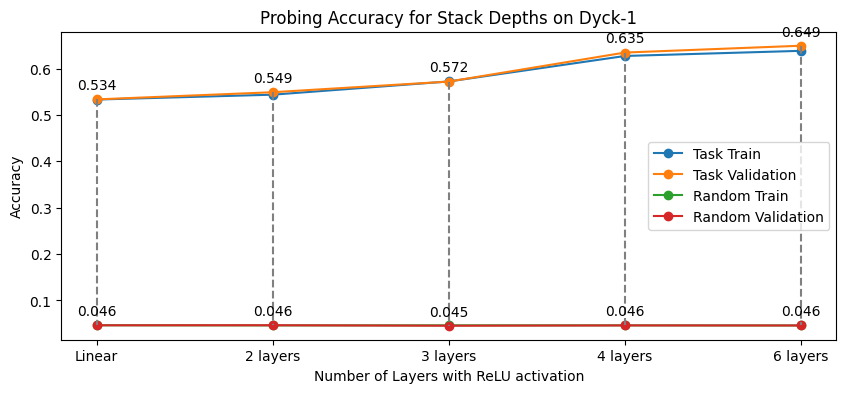

In [ ]:
import matplotlib.pyplot as plt

# Define the lists
task_train = [tm0, tm1, tm2, tm3, tm4]
task_val = [vm0, vm1, vm2, vm3, vm4]
random_train = [rm0, rm1, rm2, rm3, rm4]
random_val = [rv0, rv1, rv2, rv3, rv4]

plt.figure(figsize=(10, 4))
plt.plot(task_train, label='Task Train', marker='o')
plt.plot(task_val, label='Task Validation', marker='o')
plt.plot(random_train, label='Random Train', marker='o')
plt.plot(random_val, label='Random Validation', marker='o')

# Add vertical lines between corresponding points of task_val and random_val
for i, (tv, rv) in enumerate(zip(task_val, random_val)):
    plt.vlines(x=i, ymin=tv, ymax=rv, colors='gray', linestyles='dashed')

for i, (tv, rv) in enumerate(zip(task_val, random_val)):
    plt.annotate(f'{tv:.3f}', (i, tv), textcoords="offset points", xytext=(0,7), ha='center')
    plt.annotate(f'{rv:.3f}', (i, rv), textcoords="offset points", xytext=(0,7), ha='center')

# Add labels and title
plt.xlabel('Number of Layers with ReLU activation')
plt.ylabel('Accuracy')
plt.title('Probing Accuracy for Stack Depths on Dyck-1')

# Add a legend
plt.legend()

# Set x-axis labels
plt.xticks([0, 1, 2, 3, 4], ['Linear', '2 layers', '3 layers', '4 layers', '6 layers'])
plt.savefig('dyck1.png', dpi=300)
# Display the plot
plt.show()